# Import Packages

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm 
from PIL import Image
import os
import warnings

from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, Dropout, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint

sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

# Import labeling key from GitHub

The following code below is found in the following GitHub repository: https://github.molgen.mpg.de/mohomran/cityscapes/blob/master/scripts/helpers/labels.py#L55

This repository helper function was created by one of the team members of the CityScapes dataset

In [2]:
from collections import namedtuple

#--------------------------------------------------------------------------------
# Definitions
#--------------------------------------------------------------------------------

# a label and all meta information
Label = namedtuple( 'Label' , [

    'name'        , # The identifier of this label, e.g. 'car', 'person', ... .
                    # We use them to uniquely name a class

    'id'          , # An integer ID that is associated with this label.
                    # The IDs are used to represent the label in ground truth images
                    # An ID of -1 means that this label does not have an ID and thus
                    # is ignored when creating ground truth images (e.g. license plate).

    'trainId'     , # An integer ID that overwrites the ID above, when creating ground truth
                    # images for training.
                    # For training, multiple labels might have the same ID. Then, these labels
                    # are mapped to the same class in the ground truth images. For the inverse
                    # mapping, we use the label that is defined first in the list below.
                    # For example, mapping all void-type classes to the same ID in training,
                    # might make sense for some approaches.

    'category'    , # The name of the category that this label belongs to

    'categoryId'  , # The ID of this category. Used to create ground truth images
                    # on category level.

    'hasInstances', # Whether this label distinguishes between single instances or not

    'ignoreInEval', # Whether pixels having this class as ground truth label are ignored
                    # during evaluations or not

    'color'       , # The color of this label
    ] )


#--------------------------------------------------------------------------------
# A list of all labels
#--------------------------------------------------------------------------------

# Please adapt the train IDs as appropriate for you approach.
# Note that you might want to ignore labels with ID 255 during training.
# Make sure to provide your results using the original IDs and not the training IDs.
# Note that many IDs are ignored in evaluation and thus you never need to predict these!

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [3]:
N_FILTERS = 64
KERNEL_SIZE = 3
N_CLASSES = len(labels)
IMAGE_SIZE = [128, 128]
IMAGE_SHAPE = IMAGE_SIZE + [3,]

EPOCHS = 40
BATCH_SIZE = 16
MODEL_CHECKPOINT_FILEPATH = './cityscapes-unet.ckpt'

id2color = { label.id : np.asarray(label.color) for label in labels }

In [4]:
#--------------------------------------------------------------------------------
#  Load images in, crop for the image and mask, resize, and then encode mask
#--------------------------------------------------------------------------------

def image_mask_split(filename, image_size):
    image_mask = Image.open(filename)
    
    image, mask = image_mask.crop([0, 0, 256, 256]), image_mask.crop([256, 0, 512, 256])
    image = image.resize(image_size)
    mask = mask.resize(image_size)

    image = np.array(image) / 255 # crop image section and reformat as normalized np array
    mask = np.array(mask) # crop mask section and reformat as np array
    
    return image, mask

#--------------------------------------------------------------------------------
# Remap mask half of image into sparse matrix using closest color value
#--------------------------------------------------------------------------------

def find_closest_labels_vectorized(mask, mapping): # 'mapping' is a RGB color tuple to categorical number dictionary
    
    closest_distance = np.full([mask.shape[0], mask.shape[1]], 10000) 
    closest_category = np.full([mask.shape[0], mask.shape[1]], None)   

    for id, color in mapping.items(): # iterate over every color mapping
        dist = np.sqrt(np.linalg.norm(mask - color.reshape([1,1,-1]), axis=-1))
        is_closer = closest_distance > dist
        closest_distance = np.where(is_closer, dist, closest_distance)
        closest_category = np.where(is_closer, id, closest_category)
    
    return closest_category

# Load Datasets
The images will be loaded in using the functions defined above. The mask half of the image will need to be encoded into usable categorical values.

One issue that arose when first attempting to encode is that the image is not cleanly segmented into section.  The boundaries between categories have intermediary values.  This is most likely an artifact from anti-aliasing when the images were being resized into 256 x 512 pixels. Thus the encoding performs a loop through every categorical variables color and finds the one that is has the closest vector norm.

In [5]:
train_filepath = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/'
val_filepath = '/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/'

# Store the images, the masks, and the encoded masks
train_images = [] 
train_masks = []
train_masks_enc = []
val_images = []
val_masks = []
val_masks_enc = []

for train_file in tqdm(os.listdir(train_filepath), desc = 'Building Training Dataset: '):
    image, mask = image_mask_split(train_filepath + train_file, IMAGE_SIZE)
    train_images.append(image)
    train_masks.append(mask)
    train_masks_enc.append(find_closest_labels_vectorized(mask, id2color))
    
for val_file in tqdm(os.listdir(val_filepath), desc = 'Building Validation Dataset: '):
    image, mask = image_mask_split(val_filepath + val_file, IMAGE_SIZE)
    val_images.append(image)
    val_masks.append(mask)
    val_masks_enc.append(find_closest_labels_vectorized(mask, id2color))

Building Validation Dataset: 100%|██████████| 500/500 [00:23<00:00, 21.61it/s]


## Visualize the image, mask, and encoded mask

Lets take a look at a couple of the images and how well the encoding did.

As stated before, there is an issue with boundary edges and this is quite evident in the encoding. However, it still looks to have done a good job overall with the vast majority of each image being encoded correctly.

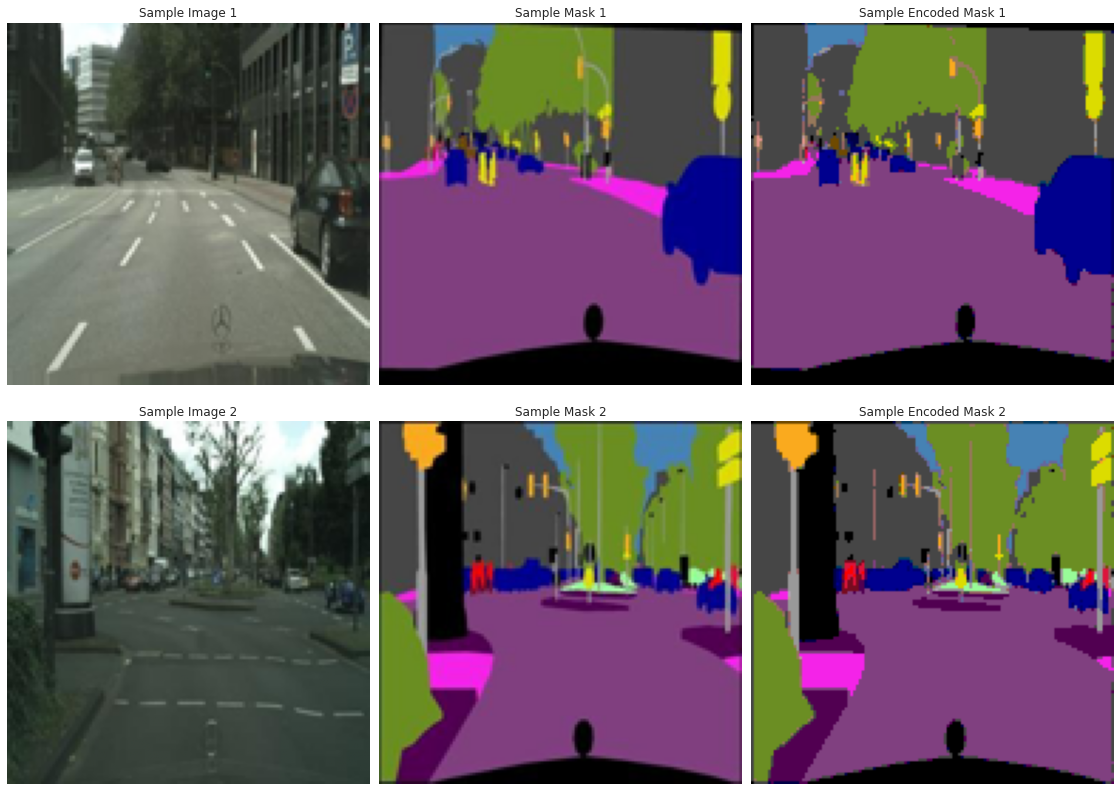

In [6]:
plt.figure(figsize=[20, 14])

for i in range(2):
    img = train_images[i]
    msk = train_masks[i]
    enc = train_masks_enc[i]
    tmp = np.zeros([enc.shape[0], enc.shape[1], 3])
    
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp[row, col, :] = id2color[enc[row, col]]
            tmp = tmp.astype('uint8')
            
    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Sample Image {}'.format(str(i+1)))
    
    plt.subplot(2, 3, i*3 + 2)
    plt.imshow(msk)
    plt.axis('off')
    plt.gca().set_title('Sample Mask {}'.format(str(i+1)))
    
    plt.subplot(2, 3, i*3 + 3)
    plt.imshow(tmp)
    plt.axis('off')
    plt.gca().set_title('Sample Encoded Mask {}'.format(str(i+1)))
    
plt.subplots_adjust(wspace=0, hspace=0.1)

In [7]:
# delete the masks as they are no longer needed to free up RAM
del train_masks, val_masks

In [8]:
train_images = np.stack(train_images).astype('float32')
train_masks_enc = np.stack(train_masks_enc).astype('float32')

val_images = np.stack(val_images).astype('float32')
val_masks_enc = np.stack(val_masks_enc).astype('float32')

# Building the U-Net Model

This functions to build this U-Net model are highly inspired by Andrew Ng's Deep Learning Specialization

There is a defined function for the downscaling convolution block and a function for the upsampling block

In [9]:
def conv_block(inputs=None, n_filters=32, kernel_size = 3, dropout_prob = 0, max_pooling=True):
    
    conv = Conv2D(n_filters, # Number of filters
                  kernel_size = 3, # Kernel size   
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(inputs)
    
    conv = Conv2D(n_filters, # Number of filters
                  kernel_size = 3,   # Kernel size
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(conv)
    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        next_layer = MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

def upsampling_block(expansive_input, contractive_input, n_filters=32, kernel_size = 3):
    
    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 kernel_size = kernel_size,    # Kernel size
                 strides = (2,2),
                 padding = 'same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters,   # Number of filters
                 kernel_size = (3,3),     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters,  # Number of filters
                 kernel_size = (3,3),   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(conv)
    
    return conv

In [10]:
def create_unet_model(image_shape, n_filters, kernel_size, n_classes):

    inputs = Input(image_shape)

    # Contracting Path (encoding)
    cblock1 = conv_block(inputs, n_filters, kernel_size)
    cblock2 = conv_block(cblock1[0], n_filters * 2, kernel_size)
    cblock3 = conv_block(cblock2[0], n_filters * 4, kernel_size, dropout_prob = 0.3)
    cblock4 = conv_block(cblock3[0], n_filters * 8, kernel_size, dropout_prob = 0.3) # Include a dropout_prob of 0.3 for this layer
    cblock5 = conv_block(cblock4[0], n_filters * 16, kernel_size, dropout_prob = 0.3, max_pooling=False) 

    # Expanding Path (decoding)
    # Add the first upsampling_block.

    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8, kernel_size)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters * 4, kernel_size)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters * 2, kernel_size)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters, kernel_size)

    conv9 = Conv2D(n_filters,
                 kernel_size = kernel_size,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Add a Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, kernel_size = 1, padding='same')(conv9)

    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    
    return model

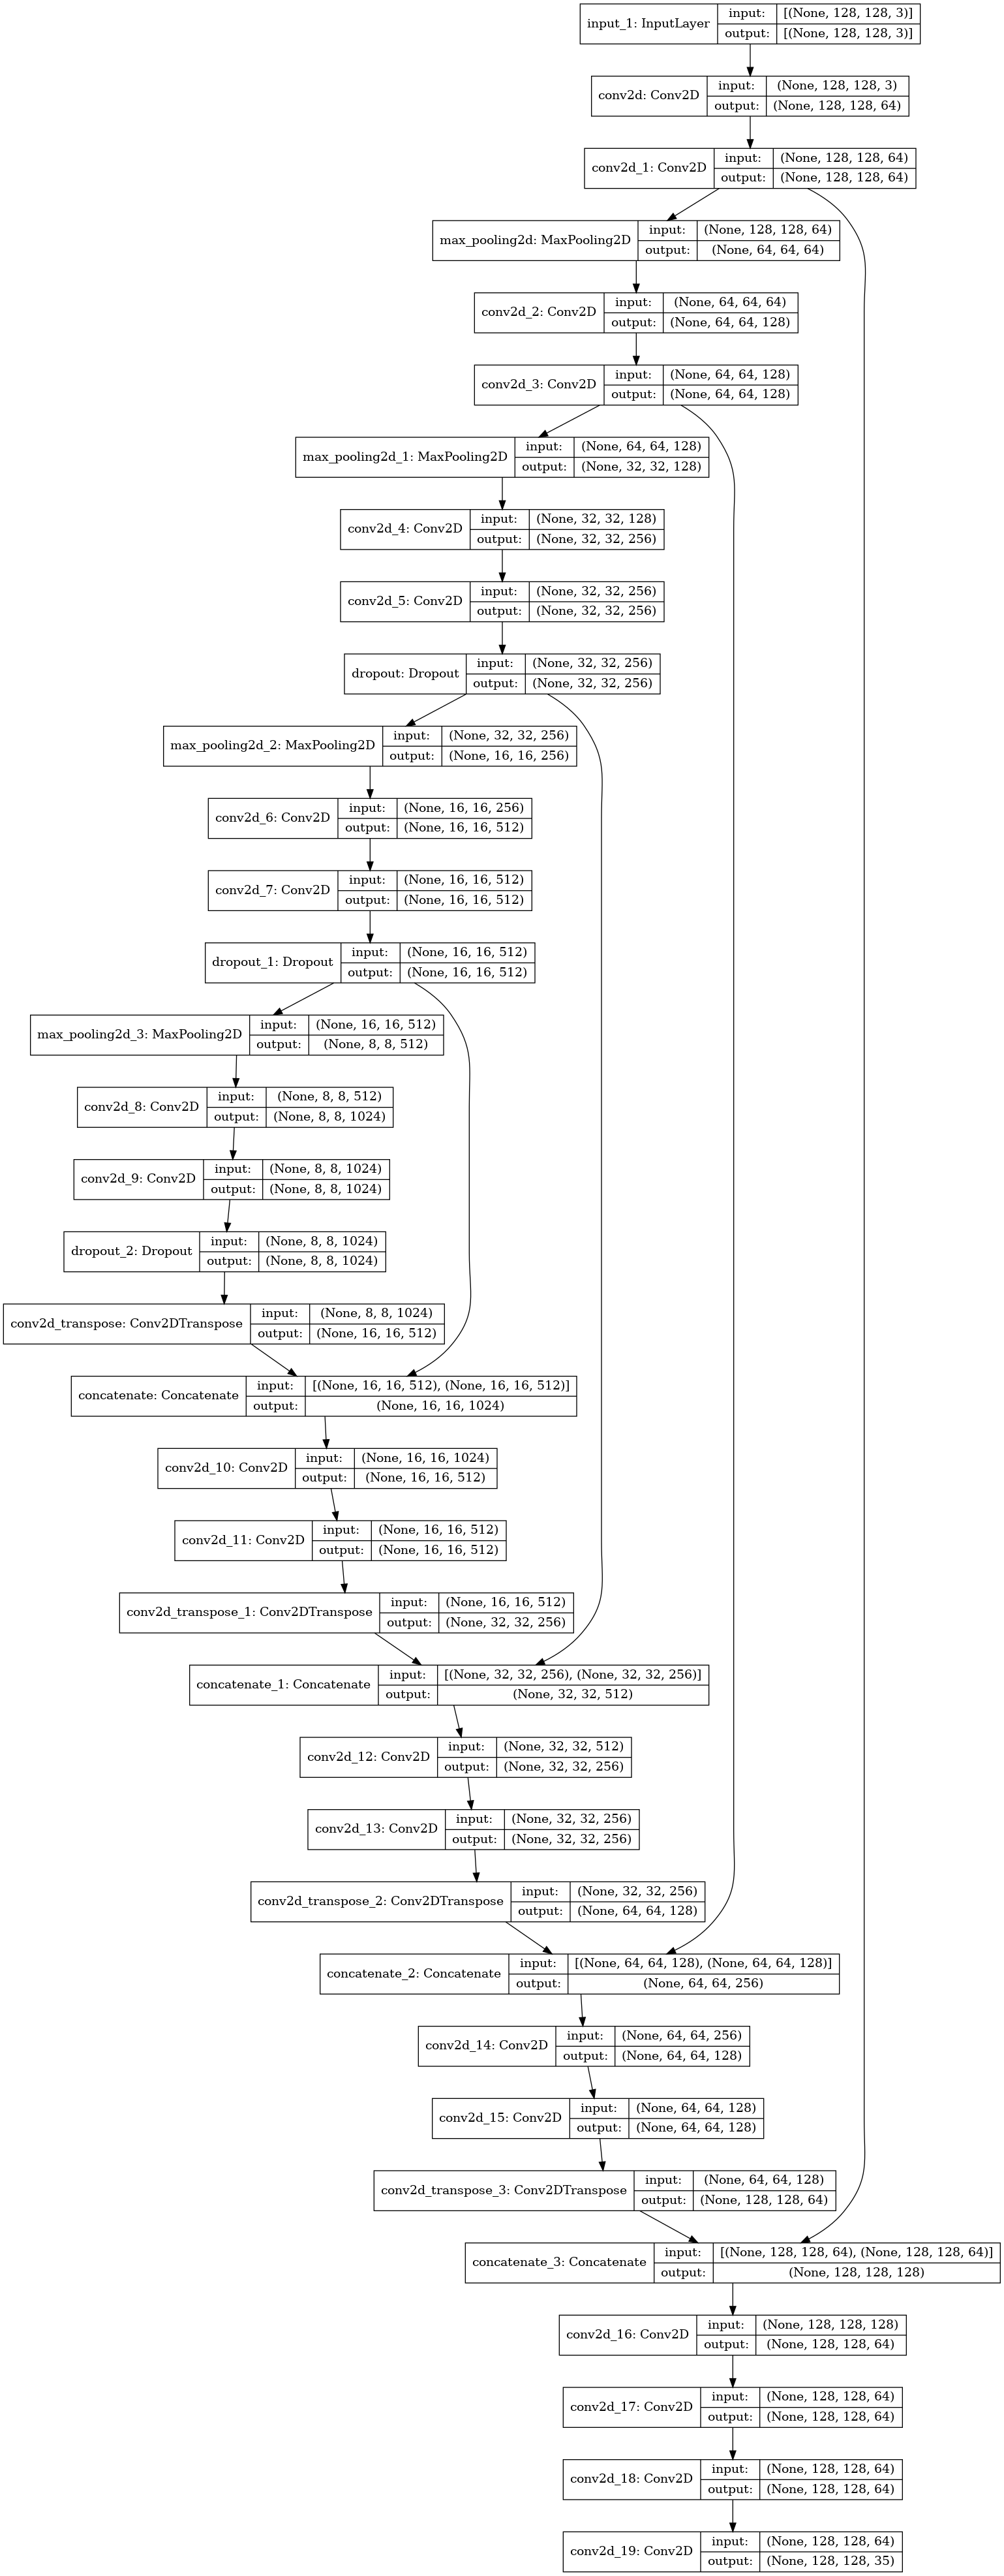

In [11]:
# use the functions to build the model and display it below
model = create_unet_model(IMAGE_SHAPE, N_FILTERS, KERNEL_SIZE, N_CLASSES)

tf.keras.utils.plot_model(model, show_shapes = True)

# Model Training

The model checkpoint callback will be used to save only the best epoch.

There is no early stopping as I want to visually see whether the model begins to overfit and to what extent.

In [12]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

model_checkpoint = ModelCheckpoint(MODEL_CHECKPOINT_FILEPATH,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   save_weights_only=True,
                                   verbose=1,
                                   mode = 'max')

callbacks = [model_checkpoint]

history = model.fit(x = train_images,
                    y = train_masks_enc,
                    batch_size = BATCH_SIZE,
                    epochs = EPOCHS,
                    validation_data = (val_images, val_masks_enc),
                    callbacks = callbacks)

Epoch 1/40
186/186 [==============================] - 69s 285ms/step - loss: 1.8182 - accuracy: 0.5135 - val_loss: 1.1659 - val_accuracy: 0.6845

Epoch 00001: val_accuracy improved from -inf to 0.68448, saving model to ./cityscapes-unet.ckpt
Epoch 2/40
186/186 [==============================] - 47s 254ms/step - loss: 1.0322 - accuracy: 0.7192 - val_loss: 0.9922 - val_accuracy: 0.7287

Epoch 00002: val_accuracy improved from 0.68448 to 0.72872, saving model to ./cityscapes-unet.ckpt
Epoch 3/40
186/186 [==============================] - 49s 261ms/step - loss: 0.9162 - accuracy: 0.7510 - val_loss: 0.9602 - val_accuracy: 0.7363

Epoch 00003: val_accuracy improved from 0.72872 to 0.73628, saving model to ./cityscapes-unet.ckpt
Epoch 4/40
186/186 [==============================] - 48s 259ms/step - loss: 0.8493 - accuracy: 0.7698 - val_loss: 0.8756 - val_accuracy: 0.7640

Epoch 00004: val_accuracy improved from 0.73628 to 0.76405, saving model to ./cityscapes-unet.ckpt
Epoch 5/40
186/186 [===

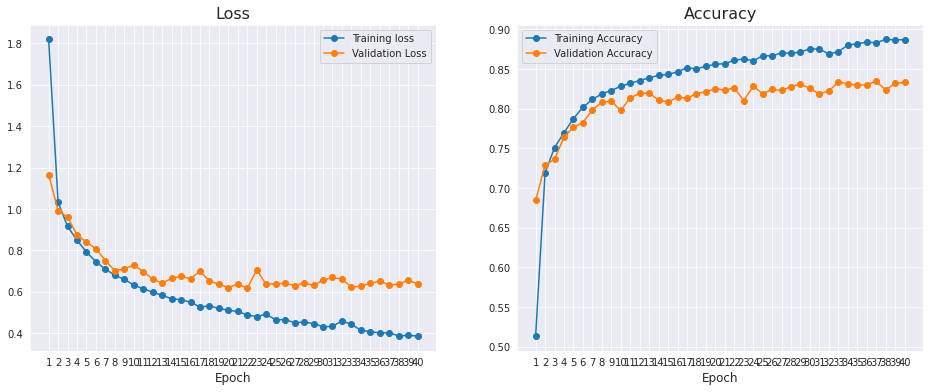

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6))
title_fontsize = 16
axis_fontsize = 12

ax1.plot(range(1, EPOCHS + 1), history.history['loss'], marker='o', label='Training loss')
ax1.plot(range(1, EPOCHS + 1), history.history['val_loss'], marker='o', label='Validation Loss')
ax1.legend()
ax1.set_xticks(range(1, EPOCHS + 1))
ax1.set_title('Loss', fontsize=title_fontsize)
ax1.set_xlabel('Epoch', fontsize=axis_fontsize)

ax2.plot(range(1, EPOCHS + 1), history.history['accuracy'], marker='o', label='Training Accuracy')
ax2.plot(range(1, EPOCHS + 1), history.history['val_accuracy'], marker='o', label='Validation Accuracy')
ax2.legend()
ax2.set_xticks(range(1, EPOCHS + 1))
ax2.set_title('Accuracy', fontsize=title_fontsize)
ax2.set_xlabel('Epoch', fontsize=axis_fontsize);

# Model Evaluation

In [14]:
model.load_weights(MODEL_CHECKPOINT_FILEPATH) # load the best model weights

val_loss, val_accuracy = model.evaluate(x = val_images, y = val_masks_enc) # re-evaluate on the validation data

print('\n\033[1m' + 'The model had an accuracy score of {}%!!'.format(round(100*val_accuracy, 2)) + '\033[0m')

16/16 [==============================] - 13s 437ms/step - loss: 0.6342 - accuracy: 0.8344

The model had an accuracy score of 83.44%!!


### Let's see how the model does on some on the validation images.

We will visually look side-by-side as the true model mask and the predicted model mask on some of the images from the validation set

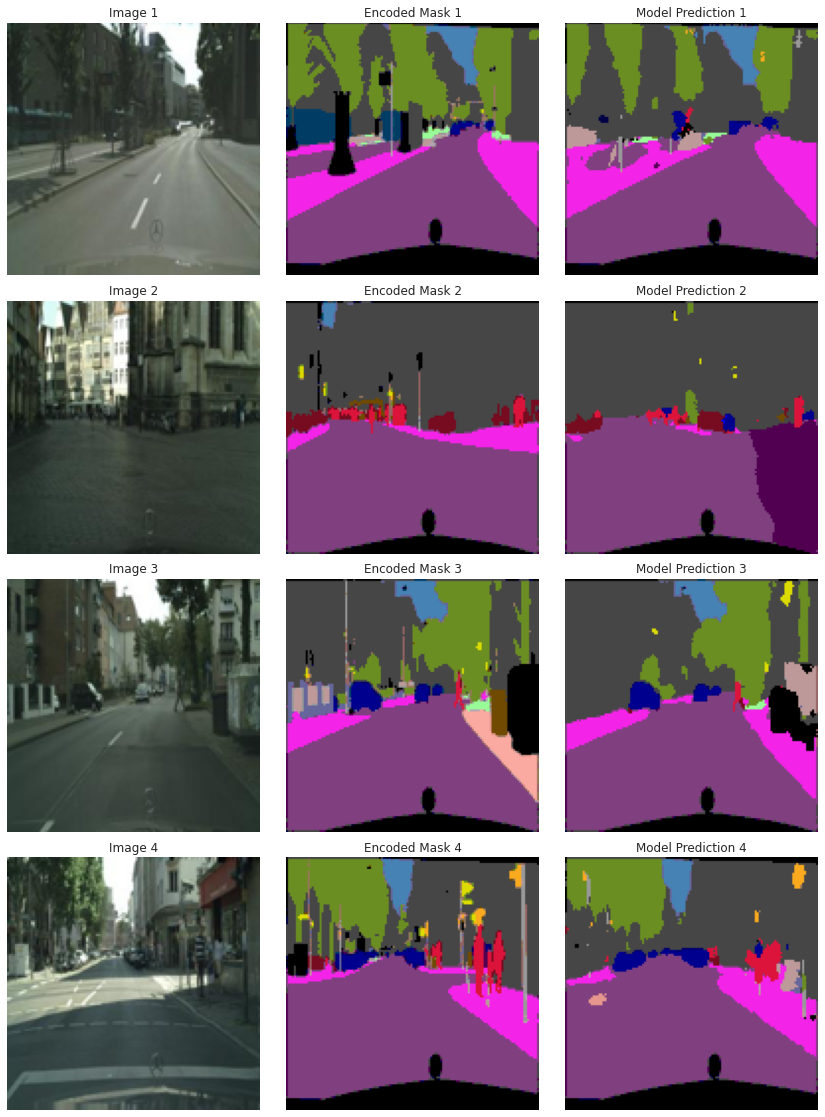

In [15]:
plt.figure(figsize=[15, 20])

for i in range(4):    
    img = val_images[i]
    enc = val_masks_enc[i]
    
    pred = model.predict(img.reshape([1] + IMAGE_SHAPE))
    pred = np.squeeze(np.argmax(pred, axis=-1))
    
    tmp1 = np.zeros([enc.shape[0], enc.shape[1], 3])
    tmp2 = np.zeros([enc.shape[0], enc.shape[1], 3])
    
    
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp1[row, col, :] = id2color[enc[row, col]]
            tmp1 = tmp1.astype('uint8')
                     
            tmp2[row, col, :] = id2color[pred[row, col]]
            tmp2 = tmp2.astype('uint8')
            
    plt.subplot(4, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Image {}'.format(str(i+1)))
    
    plt.subplot(4, 3, i*3 + 2)
    plt.imshow(tmp1)
    plt.axis('off')
    plt.gca().set_title('Encoded Mask {}'.format(str(i+1)))
    
    plt.subplot(4, 3, i*3 + 3)
    plt.imshow(tmp2)
    plt.axis('off')
    plt.gca().set_title('Model Prediction {}'.format(str(i+1)))
    
plt.subplots_adjust(wspace=0, hspace=0.1)